In [1]:
from collections import OrderedDict
import re
import os


import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm

from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names

import scienceplots
plt.style.use(['science', 'no-latex', 'light'])

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

run_dir = "../models/"

/root/miniconda3/envs/simple_functions/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/root/miniconda3/envs/simple_functions/lib/python3.8/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/root/miniconda3/envs/simple_functions/lib/p

In [2]:
df = read_run_dir(run_dir)
df  # list all the runs in our run_dir

,run_id,task,model,kwargs,num_tasks,num_examples,n_dims,n_layer,n_head,run_name
0,gpt2_run_0,gaussian_kernel_regression,Transformer,bandwidth=1.5_n_centers=20_noise_std=0.1,-1,-1,20,12,8,gaussian_kernel_regression_gpt2
1,gpt2_run_1,gaussian_kernel_regression,Transformer,bandwidth=1.5_n_centers=20_noise_std=0,-1,-1,20,12,8,gaussian_kernel_regression_gpt2
4,gpt2_run_2,gaussian_kernel_regression,Transformer,bandwidth=1.5_n_centers=20_noise_std=0,-1,-1,20,12,8,gaussian_kernel_regression_gpt2
5,gpt2_run_3,gaussian_kernel_regression,Transformer,bandwidth=1.5_n_centers=20_noise_std=0,-1,-1,20,12,8,gaussian_kernel_regression_gpt2
2,mamba_run_0,gaussian_kernel_regression,gaussian_kernel_regression_mamba_run_0,bandwidth=0.5_n_centers=10_noise_std=0.05,-1,-1,20,24,0,gaussian_kernel_regression_mamba_run_0
3,mamba_run_1,gaussian_kernel_regression,gaussian_kernel_regression_mamba_run_0,bandwidth=0.5_n_centers=10_noise_std=auto,-1,-1,20,24,0,gaussian_kernel_regression_mamba_run_0
6,mamba_run_2,gaussian_kernel_regression,gaussian_kernel_regression_mamba_run_0,bandwidth=0.5_n_centers=10_noise_std=auto,-1,-1,20,24,0,gaussian_kernel_regression_mamba_run_0
7,linear_regression_mamba,linear_regression,linear_regression_mamba,,-1,-1,20,24,0,linear_regression_mamba
8,mamba_run_0,nonlinear_dynamics,nonlinear_dynamics_mamba_run_0,noise_std=0.05_scale=3.0,-1,-1,20,24,0,nonlinear_dynamics_mamba_run_0
9,mamba_run_3,nonlinear_dynamics,nonlinear_dynamics_mamba_run_0,noise_std=0.05_scale=3.0,-1,-1,20,24,0,nonlinear_dynamics_mamba_run_0


# Plot pre-computed metrics

gaussian_kernel_regression_gpt2 gpt2_run_3


100%|██████████| 15/15 [00:00<00:00, 289928.85it/s]

>>> trying to load config from: ../models/gaussian_kernel_regression/gpt2_run_3


<Figure size 2000x1200 with 0 Axes>

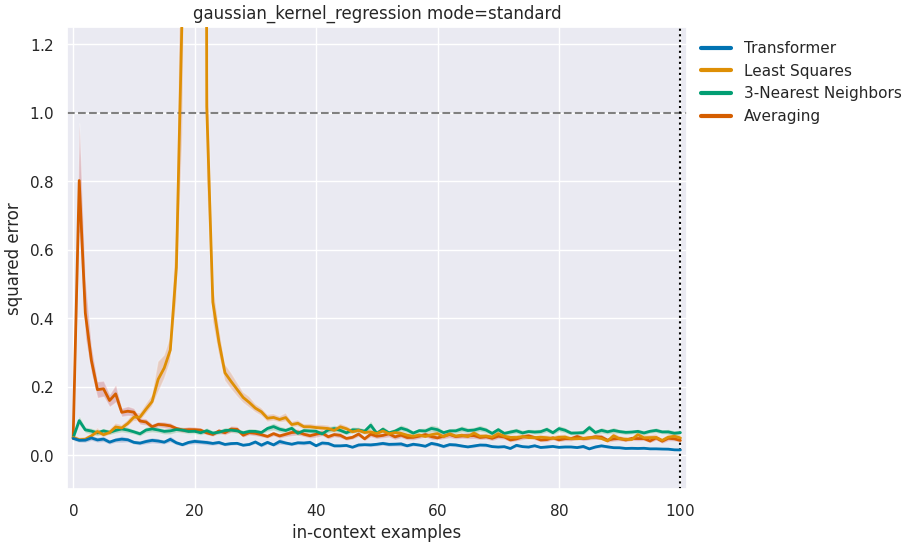

In [7]:
 # these are normally precomputed at the end of training
for task in (
    # "linear_regression",
    # "sparse_linear_regression",
    # "decision_tree",
    # "relu_2nn_regression",
    "gaussian_kernel_regression",
    # "nonlinear_dynamics",
):

    run_ids = (
        # "pretrained_mamba",
        # "pretrained",
        "gpt2_run_3",
        # "pretrained_new",
        # "pretrained_no_pos",
        # "pretrained_new_more",
        # "linear_regression_mamba",
        )  

    for run_id in run_ids:
        run_path = os.path.join(run_dir, task, run_id)
        recompute_metrics = False

        if recompute_metrics:
            get_run_metrics(run_path) 


    xlim = 200
    # xlim = 100
    # xlim = None

    def valid_row(r):
        return r.task == task and r.run_id in run_ids

    def rename_mamba(x, r):
        return x if 'mamba' not in x else 'Mamba'

    metrics = collect_results(run_dir, df, valid_row=valid_row, rename_model=rename_mamba,
                              no_recompute=True, xlim=xlim)
    print(">>> trying to load config from:", run_path)
    _, conf = get_model_from_run(run_path, only_conf=True)
    n_dims = conf.model.n_dims
    n_train_points = conf.training.curriculum.points.end



    models = [model for model in relevant_model_names[task] if model in metrics["standard"]]
    # models.remove('Mamba')
    # models.remove('Transformer')
    
    plt.figure(figsize=(20, 12))     
    basic_plot(metrics["standard"], models=models, title=f"{task} mode=standard", n_train_points=n_train_points,
               size_mult=2., size=(10, 6))
    
    # Ensure the directory exists
    output_dir = "../imgs/no_pos/"
    os.makedirs(output_dir, exist_ok=True)
    
    plt.savefig(os.path.join(output_dir, f"{task}.png"))
    plt.show()

In [6]:
metrics.keys()

dict_keys(['half_subspace', 'noisyLR', 'orthogonal_train_test', 'overlapping_train_test', 'random_quadrants', 'scale-x=0.333', 'scale-x=0.5', 'scale-x=2', 'scale-x=3', 'scale-y=0.333', 'scale-y=0.5', 'scale-y=2', 'scale-y=3', 'skewed', 'standard'])

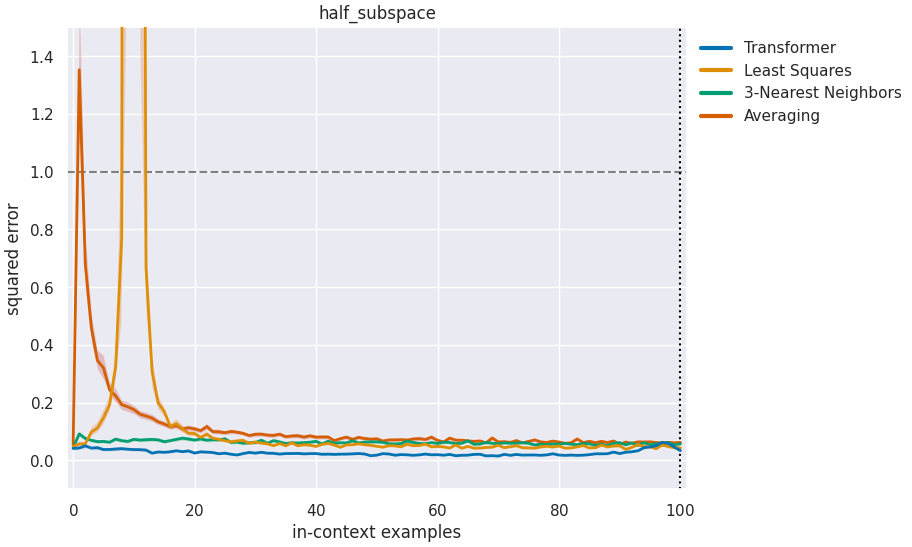

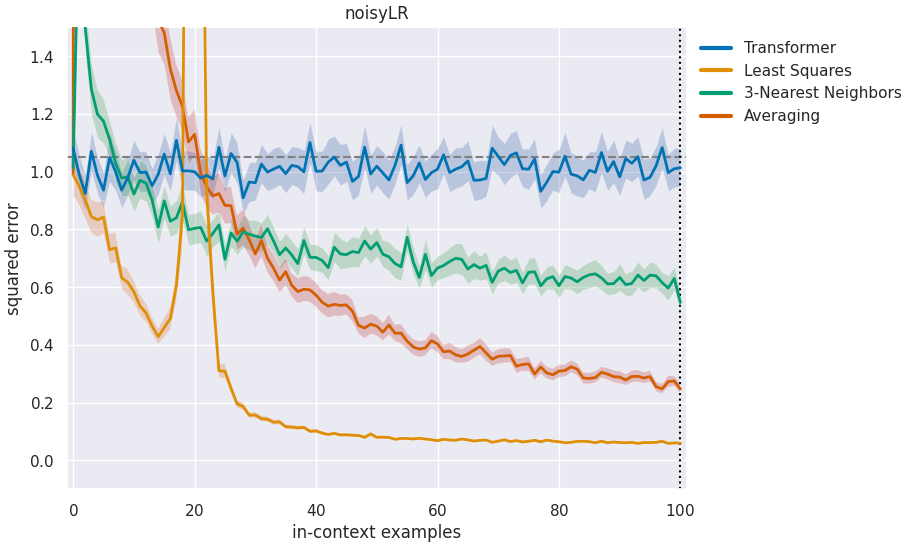

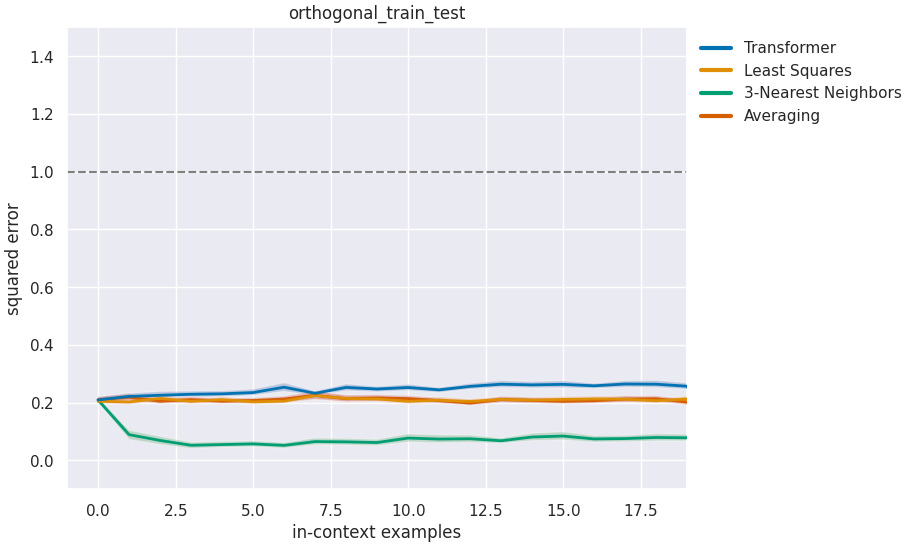

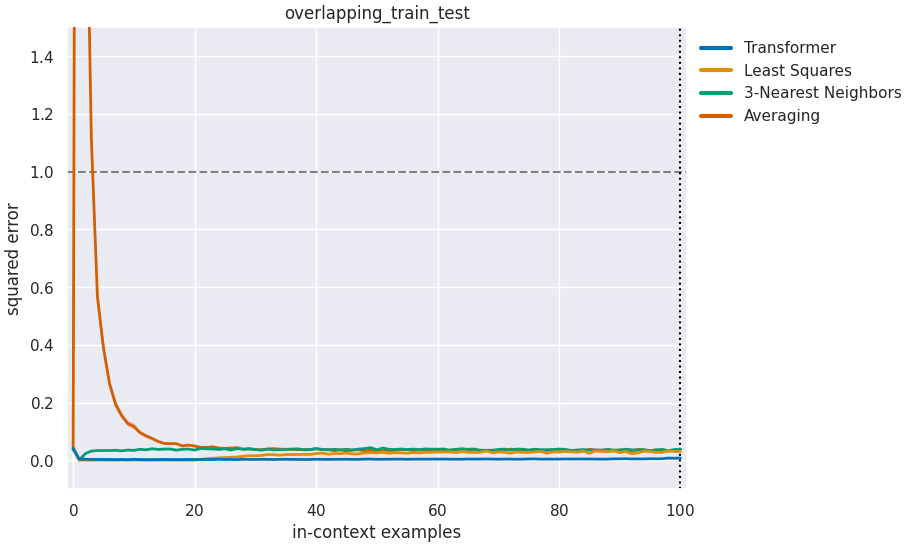

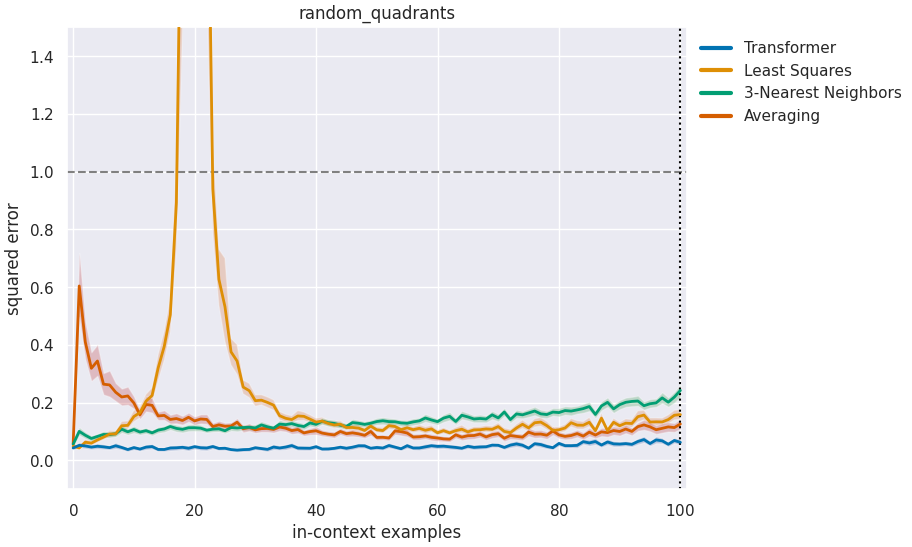

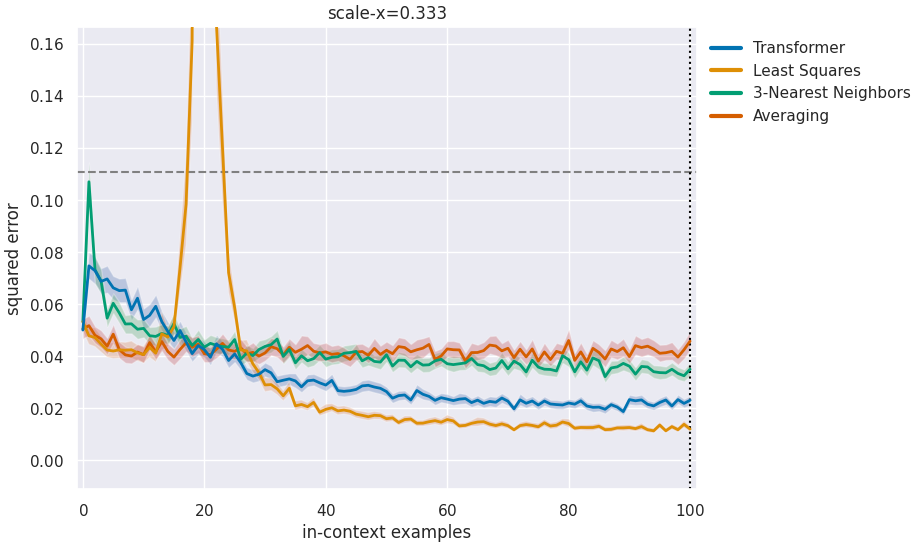

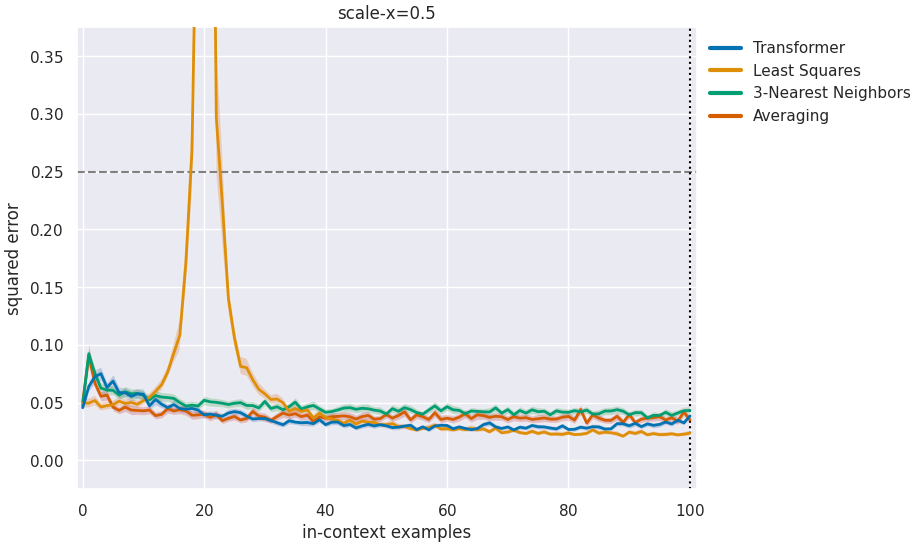

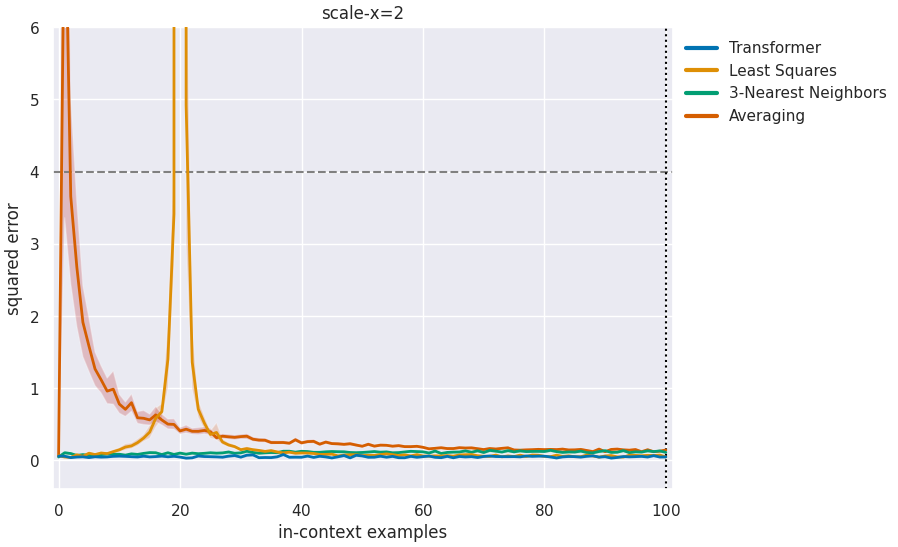

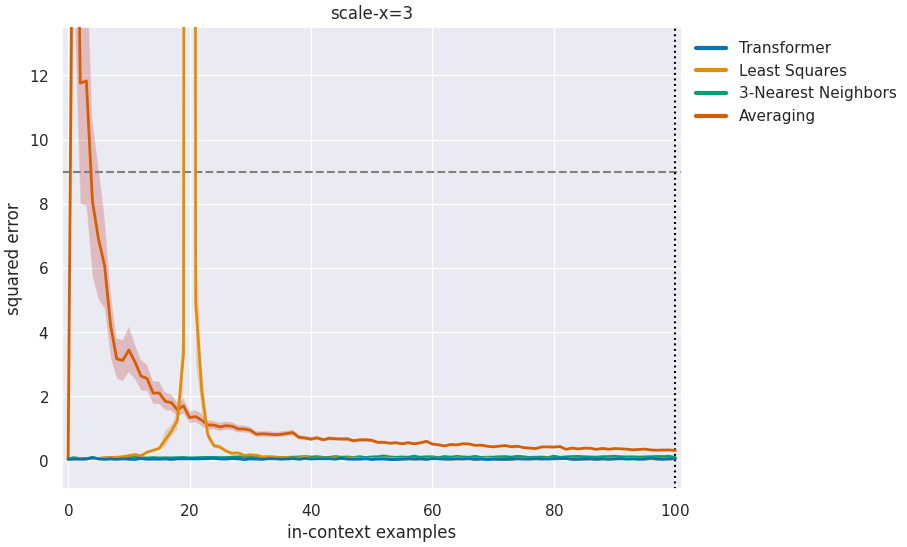

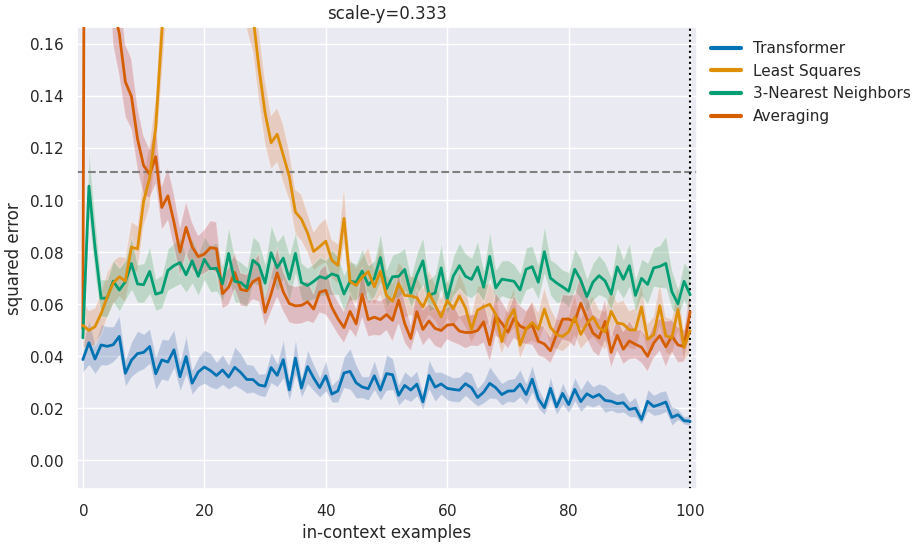

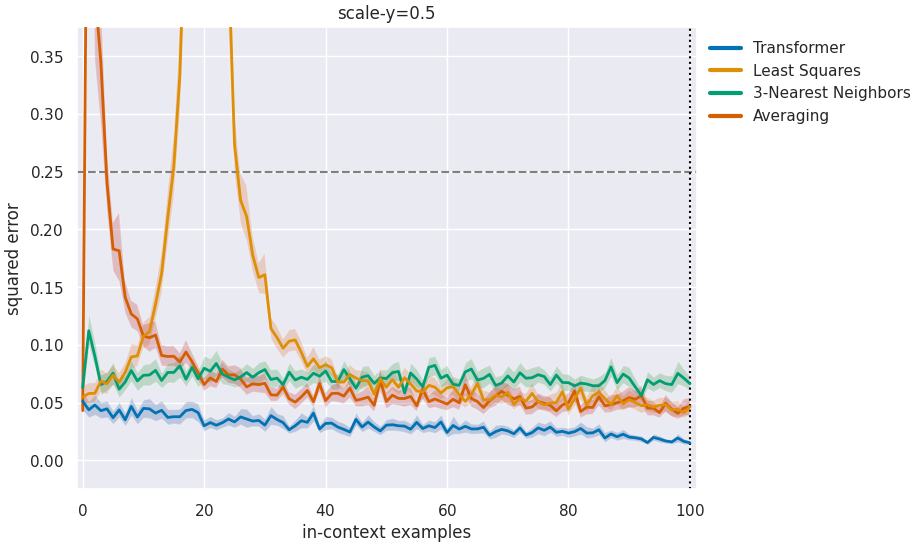

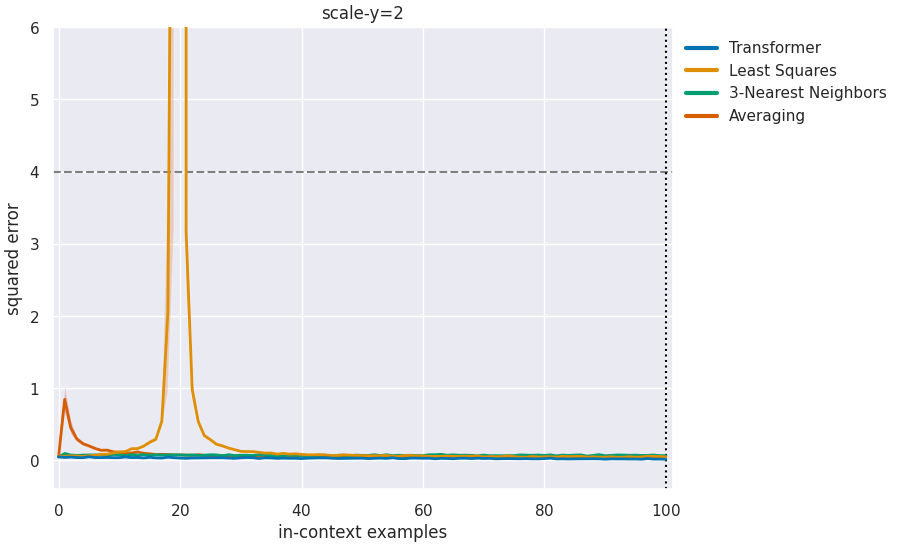

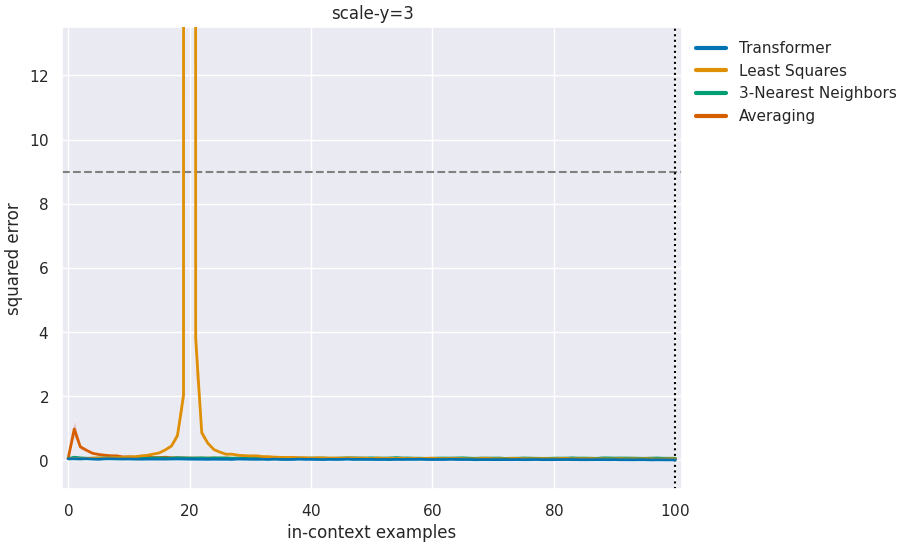

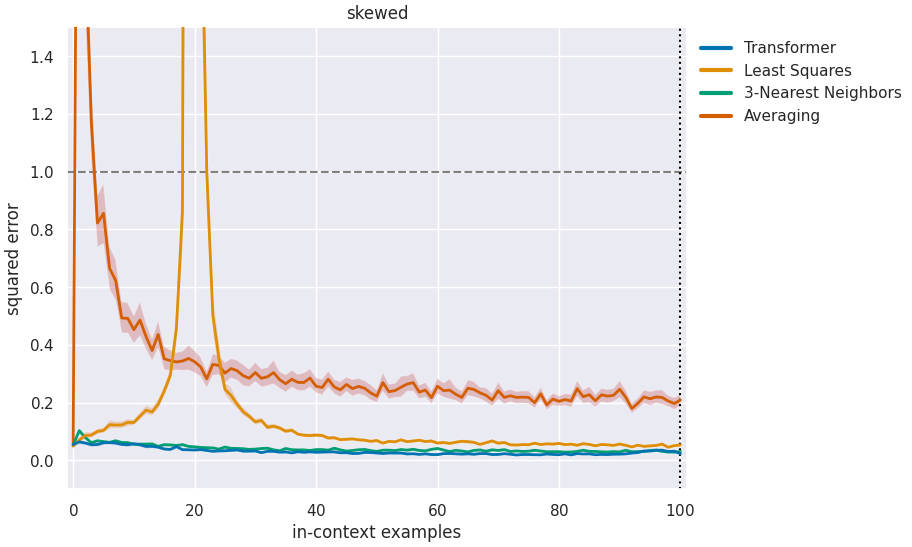

In [8]:
# plot any OOD metrics
for name, metric in metrics.items():
    if name == "standard": continue
   
    if "scale" in name:
        scale = float(name.split("=")[-1])**2
    else:
        scale = 1.0

    trivial = 1.0 if "noisy" not in name else (1+1/n_dims)
    fig, ax = basic_plot(metric, models=models, trivial=trivial * scale, size_mult=2., n_train_points=n_train_points, size=(10, 6))
    ax.set_title(name)
    
    if "ortho" in name:
        ax.set_xlim(-1, n_dims - 1)
    ax.set_ylim(-.1 * scale, 1.5 * scale)
    output_dir_ood = "../imgs/no_pos/out_of_dist/"
    os.makedirs(output_dir_ood, exist_ok=True)
    plt.savefig(os.path.join(output_dir_ood, f"{name}.png"))
    plt.show()

# Interactive setup

We will now directly load the model and measure its in-context learning ability on a batch of random inputs. (In the paper we average over multiple such batches to obtain better estimates.)

In [9]:
from samplers import get_data_sampler
from tasks import get_task_sampler

In [10]:
print(">>> trying to load config from:", run_path)

>>> trying to load config from: ../models/gaussian_kernel_regression/gpt2_run_3


In [11]:
model, conf = get_model_from_run(run_path)

n_dims = conf.model.n_dims
batch_size = conf.training.batch_size

data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    conf.training.task,
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)

In [12]:
task = task_sampler()
xs = data_sampler.sample_xs(b_size=batch_size, n_points=conf.training.curriculum.points.end)
ys = task.evaluate(xs)

In [13]:
# 把模型放到gpu上
model = model.to("cuda")
# 把数据放到gpu上
# 这里的xs和ys是torch.Tensor类型
xs = xs.to('cuda')
ys = ys.to('cuda')

In [16]:

print(xs.device)
print(ys.device)
print(model.device)
print(model.device)

cuda:0
cuda:0


AttributeError: 'TransformerModel' object has no attribute 'device'

In [14]:
with torch.no_grad():
    pred = model(xs, ys)

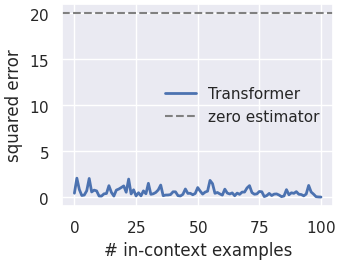

In [15]:
task_instance = task_sampler()
metric = task_instance.get_metric()
loss = metric(pred, ys).cpu().numpy()

sparsity = conf.training.task_kwargs.sparsity if "sparsity" in conf.training.task_kwargs else None
baseline = {
    "linear_regression": n_dims,
    "sparse_linear_regression": sparsity,
    "relu_2nn_regression": n_dims,
    "decision_tree": 1,
    "gaussian_kernel_regression": n_dims,
    "nonlinear_dynamics": 1,
}[conf.training.task]

plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.savefig(os.path.join(output_dir, f"{task}.png"))
plt.show()

As an exploration example, let's see how robust the model is to doubling all the inputs.

In [16]:
# xs2 = 2 * xs
# ys2 = task_instance.evaluate(xs2)
# with torch.no_grad():
#     pred2 = model(xs2, ys2)
xs2 = 2 * xs
xs2 = xs2.to('cuda')  # 移动到 centers_b 所在的设备
ys2 = task_instance.evaluate(xs2)
ys2 = ys2.to('cuda')  # 移动到 centers_b 所在的设备
with torch.no_grad():
    pred2 = model(xs2, ys2)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

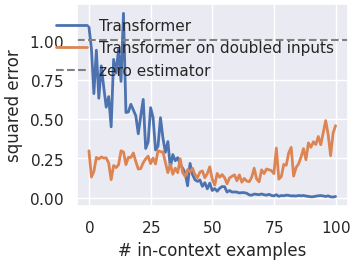

In [14]:
loss2 = metric(pred2, ys2).cpu().numpy()

plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
plt.plot(loss2.mean(axis=0) / 4, lw=2, label="Transformer on doubled inputs")
plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.savefig(os.path.join(output_dir, f"{task}_doubled.png"))
plt.show()

The error does increase, especially when the number of in-context examples exceeds the dimension, but the model is still relatively accurate.